## Copernicus Forecast Handler Module

This is a module to handle seasonal forecast data from the Copernicus Climate Data Store (CDS) in the [U-CLIMADAPT project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488). It provides functionality for downloading, processing, calculating climate indices, and creating hazard objects
based on seasonal forecast data. It is designed to work with the CLIMADA (CLIMate ADAptation) platform for climate risk
assessment and adaptation strategies.

Features:
- Download seasonal forecast data from CDS
- Process raw data into climate indices
- Calculate various heat-related indices (e.g., Heat Index, Tropical Nights)
- Create CLIMADA Hazard objects for further risk analysis
- Visualize hazard data

Prerequisites:

1. CDS account and API key:
   Register at https://cds-beta.climate.copernicus.eu

2. CDS API client installation:
   pip install cdsapi

3. CDS API configuration:
   Create a .cdsapirc file in your home directory with your API key and URL.
   For instructions, visit: https://cds-beta.climate.copernicus.eu/how-to-api#install-the-cds-api-client

Usage:
This module is typically imported and used within larger scripts or applications for climate data processing
and risk assessment. See individual function docstrings for specific usage instructions.

Note:
Ensure you have necessary permissions and comply with CDS data usage policies when using this module.

In [1]:
# import packages
import os
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

from climada.hazard import Hazard
from climada_petals.hazard.copernicus_forecast.handler import ForecastHandler
from climada.util.constants import SYSTEM_DIR
# to hide the warnings


# set path to store data
DATA_OUT = SYSTEM_DIR / "copernicus_forecast_data"
os.makedirs(DATA_OUT, exist_ok=True)

# Initialize handler
handler = ForecastHandler()

### Set up module parameters

When you are setting up the module to work with Copernicus forecast data and convert it into a hazard object for CLIMADA, you will need to configure a few key parameters. These parameters are essential because they dictate the type of data retrieved, its format, the period, and the geographic focus of the forecast data that will be transformed into a hazard model.

Bellow we describe these parameters and provide an example for the indicator tropical night to exemplify the seasonal forescast handler's funtionality.

To learn more about what these parameters entail and their significance, please refer to the [documentation on the CDS webpage](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).

#### Overview of parameters

**tf_index**: Defines the type of index to be calculated. The current options available are 'HIA' (Heat Index Adjusted), 'HIS' (Heat Index Simplified), 'Tmean' (Mean Temperature), 'HW' (Heat Wave), and 'TR' (Tropical Nights), 'TX30' (HotDays).

**format** : Specifies the format of the data to be downloaded. Currently, only the "grib" format is  available, but "netcdf" will be supported in the future. Noted that GRIB files are more complex and slower to process compared to NetCDF.

**originating_centre**: Identifies the source of the data. A standard choice is "dwd" (German Weather Service), one of eight providers including ECMWF, UK Met Office, Météo France, CMCC, NCEP, JMA, and ECCC.

**system**: Refers to a specific model or system used for forecasts. A standard choice is "21", which indicates a particular system version or model configuration. More details are in the [CDS documentation](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=documentation).

**max_lead_month**: Defines the maximum lead time in months for forecast data. For this example we set it to 4 months, meaning forecasts up to four months into the future. The maximum available is 7 months.

**year_list**: A list of years for which data should be downloaded and processed.

**month_list**: Starting months for seasonal forecast data. [6, 7] means data starts from June and July.

**area_selection**: This determines the geographical area for which the data should be downloaded. It can be set to
- "global" (gobal data is downloaded)
- a list of ISO alpha-3 codes for different countries, e.g., ["DEU", "CHE"] for Germany and Switzerland. See this [wikipedia page](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for the country codes. Note that the **joint region** will be downloaded and processed, i.e., handling data for ["DEU", "CHE"] and then for ["CHE"] will download and generate two sets of data.
- a list of four numbers corresponding to the geographical bounds (in degrees; EPSG:4326), specified as [north, west, south, east]. 

**overwrite**: Boolean flag that, when set to True, forces the system to redownload and reprocess existing files.


** TO DO : Ensure the code runs on different platforms (Linux, Windows, macOS).**
Defensive programming to error handling, ensures that any function can handle unexpected inputs, regardless of how it was called, for example no in the context of this tutorial 

In [13]:
# We define above parameters for an example 
tf_index = "Tmean" # tropical nights
format = "grib"  # 'grib' or 'netcdf'
originating_centre = "dwd"
system = "21"
max_lead_month = 4
year_list = [2022]
month_list = [6, 7]
area_selection = ['DEU', 'CHE']  
overwrite = False

# Details on the characteristics of the selected indicator and the input data used
handler.explain_index(tf_index)

Explanation for 'Tmean': Mean Temperature: This indicator calculates the average temperature over the specified period.
Required Input Data: ['2m temperature (t2m)']


### Download and Process Data

The `handler.download_and_process_data` method in CLIMADA efficiently retrieves and organizes Copernicus forecast data. It checks for existing files to avoid redundant downloads, stores data by format (grib or netCDF), year, month. Then the files are processed for further analysis, such as calculating climate indices or creating hazard objects within CLIMADA. Here are the aspects of this process:

- **Data Download**: The method downloads the forecast data for the selected years, months, and regions. The data is retrieved in **grib** format, which is commonly used for storing meteorological data. If the required grib files already exist in the specified directories, the system will skip downloading them, as indicated by the log messages such as:  
  *"Corresponding grib file SYSTEM_DIR/copernicus_forecast_data/input_data/grib/2022/06/t2m_area4_56_45_16_202206.grib already exists."*

- **Data Processing**: After downloading (or confirming the existence of) the grib files, the system converts them into daily **netCDF** files. This format s useful for working with multi-dimensional climate data, especially for specific indices such as temperature or precipitation. The log messages confirm the existence or creation of these files, for example:  
  *"Daily file SYSTEM_DIR/copernicus_forecast_data/input_data/netcdf/daily/2022/06/t2m_area4_56_45_16_202206.nc already exists."*

- **Geographic and Temporal Focus**: The files are generated for a specific time frame (e.g., June and July 2022) and a predefined geographic region, as specified by the parameters such as `area_selection`, `month_list`, and `year_list`. This ensures that only the selected data for your analysis is downloaded and processed.

- **Data Completeness**: Messages like "already exists" ensure that you do not redundantly download or process data, saving time and computing resources. However, if the data files are missing, they will be downloaded and processed as necessary.

In [14]:
# Download and process data
handler.download_and_process_data(tf_index, DATA_OUT, year_list, month_list, area_selection, overwrite, format, originating_centre, system, max_lead_month)

2024-09-30 18:34:19,295 | INFO : File /Users/daraya/climada/data/copernicus_forecast_data/input_data/grib/2022/06/t2m_area4_56_45_16_202206.grib already exists.
2024-09-30 18:34:19,296 | INFO : File /Users/daraya/climada/data/copernicus_forecast_data/input_data/grib/2022/07/t2m_area4_56_45_16_202207.grib already exists.
2024-09-30 18:34:19,297 | INFO : Daily file /Users/daraya/climada/data/copernicus_forecast_data/input_data/netcdf/daily/2022/06/t2m_area4_56_45_16_202206.nc already exists.
2024-09-30 18:34:19,297 | INFO : Daily file /Users/daraya/climada/data/copernicus_forecast_data/input_data/netcdf/daily/2022/07/t2m_area4_56_45_16_202207.nc already exists.


### Calculate Climate Indices

When you use the `handler.calculate_index` method in CLIMADA to compute specific climate indices (such as Tropical Nights), the generated output is saved and organized in a structured format for further analysis. Here some details:

- **Index Calculation**: The method processes seasonal forecast data to compute the selected index for the chosen years, months, and regions. This index represents a specific climate condition, such as the number of Tropical Nights ("TR") over the forecast period, as defined in the parameters.

- **Data Storage**: The calculated index data is saved in **netCDF** format. These files are automatically saved in directories specific to the index and time period. The file paths are printed below the processing steps. For example, the computed index values are stored in:  
  *"/Users/daraya/Documents/CLIMADA/climada_petals/results/copernicus_forecast_data/TR/2022/TR_202206.nc"*

  Similarly, the statistics of the index (e.g., mean, variance) are saved in:  
  *"/Users/daraya/Documents/CLIMADA/climada_petals/results/copernicus_forecast_data/TR/2022/stats/TR_202206_statistics.nc"*.  
  These files ensure that both the raw indices and their statistical summaries are available for detailed analysis.
  
  Each file contains data for a specific month and geographic region, as defined in the parameters. This allows you to analyze how the selected climate index varies over time and across different locations.

- **Completeness of Data Processing**: Messages like 'Tropical nights saved to...' confirm the successful calculation and storage of the index, ensuring that all requested data has been processed and saved correctly.


In [16]:
# Calculate index
handler.calculate_index(tf_index, DATA_OUT, year_list, month_list, area_selection, overwrite)

2024-09-30 18:35:33,331 | INFO : Index file /Users/daraya/climada/data/copernicus_forecast_data/indeces/Tmean/2022/06/Tmean_area4_56_45_16_202206.nc already exists.
2024-09-30 18:35:33,332 | INFO : Index file /Users/daraya/climada/data/copernicus_forecast_data/indeces/Tmean/2022/07/Tmean_area4_56_45_16_202207.nc already exists.


### Calculate a Hazard Object

When you use the `handler.process_and_save_hazards` method in CLIMADA to convert processed index from Copernicus forecast data into a hazard object:

- **Hazard Object Creation**: The method processes seasonal forecast data for specified years and months, converting these into hazard objects. These objects encapsulate potential risks associated with specific weather events or conditions, such as Tropical Nights ('TR') indicated in the parameters, over the forecast period.

- **Data Storage**: The hazard data for each ensemble member of the forecast is saved as HDF5 files. These files are automatically stored in specific directories corresponding to each month and type of hazard. The file paths are printed below the processing steps. For example, *"/Users/daraya/Documents/CLIMADA/climada_petals/results/copernicus_forecast_data/TR/hazard/202206/hazard_TR_member_0_202206.hdf5"*
 HDF5 is a versatile data model that efficiently stores large volumes of complex data.
 
 Each file is specific to a particular month and hazard scenario ('TR' in this case) and covers all ensemble members for that forecast period, aiding in detailed risk analysis.

- **Completeness of Data Processing**: Messages like 'Completed processing for 2022-07. Data saved in...' confirm the successful processing and storage of the hazard data for that period, ensuring that all requested data has been properly handled and stored.

#### Visualizing the Calculated Hazard Object

Once the hazard object has been successfully calculated, the last element created is printed for visualization. This is important for several reasons:

- **Initial Data Inspection**: The visualization allows you to view a slice of the forecast data, providing a quick check of the results. This initial glimpse helps you verify that the data processing was successful and provides insights into the distribution of the hazard (in this case, Tropical Nights) across the area of interest.

- **Geographic Accuracy**: The map helps you verify if the correct geographic region was processed and plotted. This is particularly useful as it allows immediate feedback on whether the user-defined boundaries or selected areas (e.g., Germany and Switzerland) were captured correctly.

- **Data Quality Check**: Visualizing the output also serves as a preliminary quality check, allowing you to detect any unexpected results or anomalies in the data. For instance, the color bar indicating the "Intensity (days)" gives an indication of how the hazard index is distributed across the mapped area.

- **Quick Workflow Testing**: This step is essential for testing the entire workflow, ensuring that the process is working as expected from data download, processing, and hazard object creation to visualization.

This output provides a structured dataset ready for further analysis within the CLIMADA framework, allowing for the evaluation of potential impacts and the planning of mitigation strategies. 


2024-09-30 18:35:39,784 - climada.hazard.io - INFO - Writing /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/06/hazard_Tmean_area4_56_45_16_202206.hdf5
2024-09-30 18:35:39,806 - climada.hazard.centroids.centr - INFO - Writing /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/06/hazard_Tmean_area4_56_45_16_202206.hdf5
Completed processing for 2022-06. Data saved in /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/06.
2024-09-30 18:35:40,264 - climada.hazard.io - INFO - Writing /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/07/hazard_Tmean_area4_56_45_16_202207.hdf5
2024-09-30 18:35:40,286 - climada.hazard.centroids.centr - INFO - Writing /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/07/hazard_Tmean_area4_56_45_16_202207.hdf5
Completed processing for 2022-07. Data saved in /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/07.
2024-09-30 18:35:40,291 - climada.

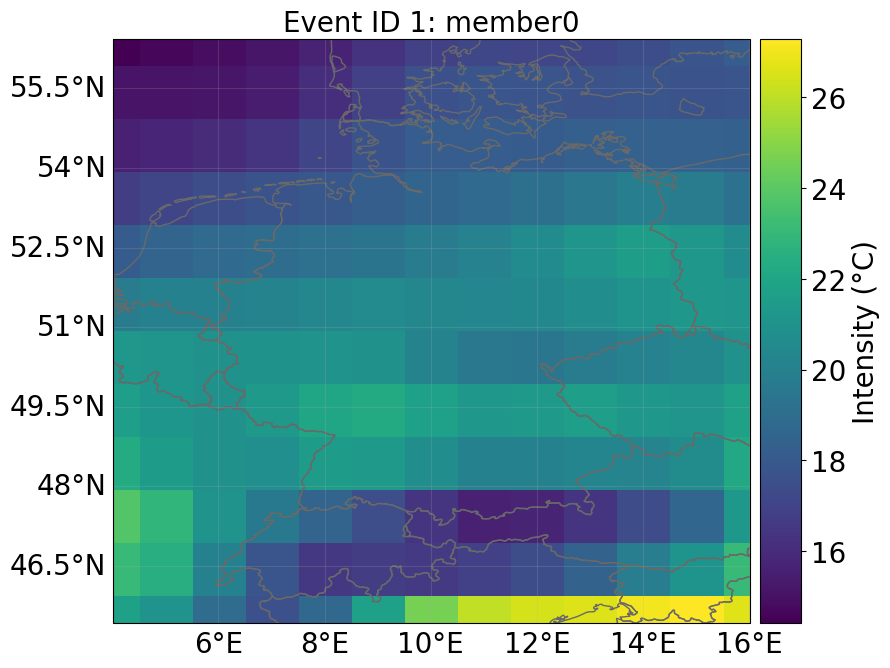

In [17]:
handler.save_index_to_hazard(tf_index, year_list, month_list, area_selection, DATA_OUT, overwrite)

## Example for reading and plotting hazard

The saved hazard file can then be read and processed by standard CLIMADA methods. For instance, below, we load the hazard for the last month and plot the intensity per grid point maximized over all forecast ensemble members.

2024-09-30 18:35:48,963 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast_data/hazard/Tmean/2022/07/hazard_Tmean_area4_56_45_16_202207.hdf5


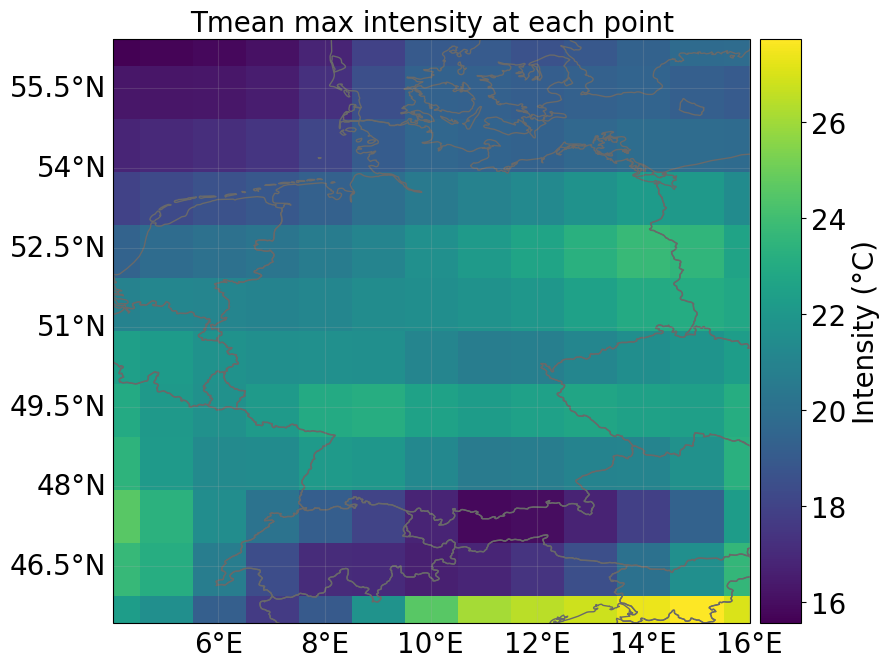

In [18]:
# choose example hazard
year = year_list[-1]
month = month_list[-1]
ordinal_date = dt.datetime.fromisoformat(f'{year}-{month:02d}-01').toordinal()
bounds = handler._get_bounds_for_area_selection(area_selection)
area_str = f"area{int(bounds[1])}_{int(bounds[0])}_{int(bounds[2])}_{int(bounds[3])}"

# hazard path
hazard_directory = f'{DATA_OUT}/hazard/{tf_index}/{year}/{month:02d}'
hazard_path = f'{hazard_directory}/hazard_{tf_index}_{area_str}_{year}{month:02d}.hdf5'

# load hazard and plot intensity for each grid maximized over ensemble
haz = Hazard.from_hdf5(hazard_path)
haz.select(date=[ordinal_date, ordinal_date]).plot_intensity(event=0, smooth=False);